In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller


import sys
import os

# Obtener la ruta absoluta a la carpeta 'function'
# Sube un nivel desde 'notebooks' y luego entra a 'function'
function_path = os.path.abspath(os.path.join('..', 'function'))

# Añadir la ruta al sys.path si no está ya ahí
# Esto evita añadir la ruta múltiples veces si ejecutas la celda de nuevo
if function_path not in sys.path:
    sys.path.append(function_path)

# Ahora puedes importar tus módulos
from Methodologies_Port import *
from metrics_portfolio import *
from Portafolio_DeFi import *
from yahoo_data import *

# 2) Media-varianza eficiente

## A)

In [2]:
import numpy as np

def min_var_portfolio_weights(Sigma):
    """
    Pesos del portafolio de varianza mínima (MVP) sin restricciones de caja.
    Parámetro
    ---------
    Sigma : array-like (n x n)
        Matriz de covarianzas.
    Retorna
    -------
    w : np.ndarray (n,)
        Vector de pesos que suma 1.
    """
    Sigma = np.asarray(Sigma, dtype=float)
    n = Sigma.shape[0]
    ones = np.ones(n)
    invS = np.linalg.inv(Sigma)
    w = invS @ ones
    w = w / (ones @ invS @ ones)
    return w


Sigma = np.array([[0.0180, 0.0045],
                  [0.0045, 0.0100]])

w_mvp = min_var_portfolio_weights(Sigma)
print(w_mvp)          



[0.28947368 0.71052632]


[0.28947368 0.71052632]
pesos optimos: 29% en el Activo 1 y 71% en el Activo 2.
es la mezcla más estable posible con esos dos activos (la menor varianza mensual), sin vender en corto.

## B)

In [3]:
def mean_variance_target_return(mu, Sigma, R_target):
    """
    Pesos que minimizan la varianza con retorno objetivo R_target.
    """
    mu = np.asarray(mu, dtype=float).reshape(-1)
    Sigma = np.asarray(Sigma, dtype=float)
    n = mu.size
    invS = np.linalg.inv(Sigma)
    ones = np.ones(n)

    A = ones @ invS @ ones
    B = ones @ invS @ mu
    C = mu  @ invS @ mu

    M   = np.array([[A, B], [B, C]], dtype=float)
    rhs = np.array([1.0, R_target], dtype=float)
    alpha, beta = np.linalg.solve(M, rhs)

    w = alpha * (invS @ ones) + beta * (invS @ mu)
    return w



In [4]:
# Datos del enunciado:
mu = np.array([0.012, 0.007])
Sigma = np.array([[0.0180, 0.0045],
                  [0.0045, 0.0100]])

w = mean_variance_target_return(mu=mu, Sigma=Sigma, R_target=0.010)
print("Pesos óptimos (w*):", w)

print("Suma de pesos:", w.sum())
print("Retorno objetivo alcanzado:", float(w @ mu))
var_p = float(w.T @ Sigma @ w)
print("Varianza mínima:", var_p)
print("Volatilidad mínima:", np.sqrt(var_p))

Pesos óptimos (w*): [0.6 0.4]
Suma de pesos: 1.0
Retorno objetivo alcanzado: 0.01
Varianza mínima: 0.010239999999999999
Volatilidad mínima: 0.10119288512538814


Pesos óptimos: 60% en el Activo 1 y 40% en el Activo 2.
Se cumple la meta: el portafolio entrega 1.0% mensual esperado y los pesos suman 1.

Riesgo mínimo para esa meta: su volatilidad queda en ~10.1% mensual; cualquier otra mezcla que también logre 1% tendría más riesgo.

# 3) Series de tiempo: ADF, ACF Y PACF

## A)

In [5]:
# Retornos logarítmicos r_t = ln(P_t) - ln(P_{t-1}) para BTC-USD 
ticker = 'BTC-USD'
start, end = '2025-04-30', '2025-09-08'

# Precios diarios (Adj Close)
prices_btc = yahoo_data.download_data(ticker, start, end, price_col="Adj Close", auto_adjust=False)

# Log-retornos
r_btc_log = yahoo_data.compute_returns_from_prices(prices_btc, kind='log')
r_btc_log.columns = ['r_log']  # nombre claro para el reporte


print("Ventana:", r_btc_log.index.min().date(), "->", r_btc_log.index.max().date(), f"({len(r_btc_log)} obs.)")
print("\nPrimeros 5 log-retornos:")
print(r_btc_log.head().round(6))
print("\nÚltimos 5 log-retornos:")
print(r_btc_log.tail().round(6))



Ventana: 2025-05-01 -> 2025-09-07 (130 obs.)

Primeros 5 log-retornos:
               r_log
Date                
2025-05-01  0.023966
2025-05-02  0.004320
2025-05-03 -0.010563
2025-05-04 -0.016570
2025-05-05  0.004571

Últimos 5 log-retornos:
               r_log
Date                
2025-09-03  0.004689
2025-09-04 -0.008987
2025-09-05 -0.000656
2025-09-06 -0.003860
2025-09-07  0.008518


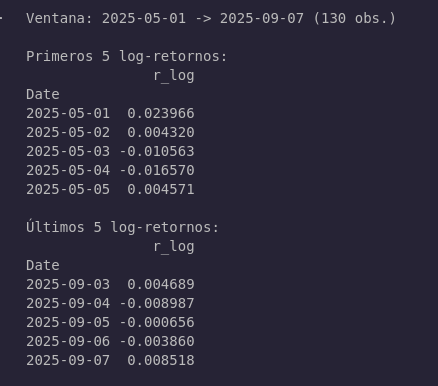

La serie de 130 log-retornos diarios de BTC-USD (01-May-2025 → 07-Sep-2025) quedó correctamente construida a partir del “Adj Close”. Los cambios diarios son de pocos puntos porcentuales, con signos alternos y sin tendencia evidente, lista para aplicar ADF/ACF/PACF.

## B)

In [6]:
from statsmodels.tsa.stattools import adfuller

# Log-retornos r_t = ln P_t - ln P_{t-1}  (yahoo_data.py: compute_returns_from_prices)
r_btc_log = yahoo_data.compute_returns_from_prices(prices_btc, kind='log')
r_btc_log.columns = ['r_log']   # nombre claro
s = r_btc_log['r_log'].dropna() # Serie 1D sin NA

#  Prueba ADF (con constante, autolag por AIC)
adft = adfuller(s, autolag='AIC')

output_df = pd.DataFrame({
    'Metrics': ['Test Statistic', 'p-value', 'No. of lags used', 'No. obs used',
                'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)'],
    'Values':  [adft[0], adft[1], adft[2], adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]
})

print(output_df)

#  Decisión al 5%
alpha = 0.05
decision = "ESTACIONARIA (rechazo H0 de raíz unitaria)" if adft[1] < alpha else "NO estacionaria (no rechazo H0)"
print(f"\nDecisión @5%: {decision}")



                Metrics        Values
0        Test Statistic -1.186604e+01
1               p-value  6.672011e-22
2      No. of lags used  0.000000e+00
3          No. obs used  1.290000e+02
4   Critical Value (1%) -3.482088e+00
5   Critical Value (5%) -2.884219e+00
6  Critical Value (10%) -2.578864e+00

Decisión @5%: ESTACIONARIA (rechazo H0 de raíz unitaria)


Conclusión 3-b: Los log-retornos de BTC-USD son estacionarios. El ADF rechaza raíz unitaria con p≈6.7e-22 y estadístico −11.9 (< críticos). No hace falta diferenciar; puedes modelar directamente (ACF/PACF/ARMA sobre r)

### C

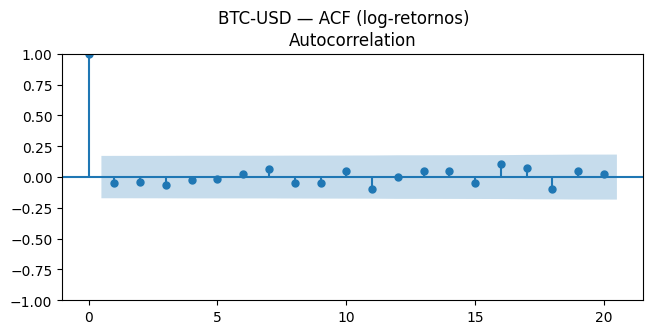

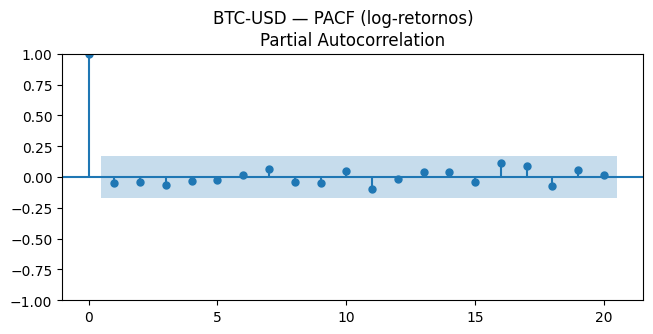

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

s = r_btc_log['r_log'].dropna()

# Correlogramas (20 rezagos)
fig1 = plot_acf(s, lags=20, fft=True, alpha=0.05)
fig1.set_size_inches(7.5, 3.2)
fig1.suptitle('BTC-USD — ACF (log-retornos)', y=1.02)

fig2 = plot_pacf(s, lags=20, method='ywm', alpha=0.05)
fig2.set_size_inches(7.5, 3.2)
fig2.suptitle('BTC-USD — PACF (log-retornos)', y=1.02)

plt.show()



**Conclusión 3-c:** La ACF y la PACF no muestran picos significativos (casi todo dentro del intervalo). No hay estructura AR ni MA clara → los log-retornos se comportan como **ruido blanco**. Si acaso, solo un efecto **lag-1 muy débil**.


# 4)

## a)

In [8]:
# (Usamos la serie de log-retornos ya creada: s = r_btc_log['r_log'].dropna())

from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Modelos con d=0 (ya verificamos estacionariedad). Incluyen constante por defecto (trend='c').
m_ar1    = ARIMA(s, order=(1,0,0)).fit()
m_ma1    = ARIMA(s, order=(0,0,1)).fit()
m_arma11 = ARIMA(s, order=(1,0,1)).fit()

# Tabla breve de verosimilitud / información
tabla_fit = pd.DataFrame({
    'Modelo' : ['AR(1)', 'MA(1)', 'ARMA(1,1)'],
    'AIC'    : [m_ar1.aic, m_ma1.aic, m_arma11.aic],
    'BIC'    : [m_ar1.bic, m_ma1.bic, m_arma11.bic],
    'LogLik' : [m_ar1.llf, m_ma1.llf, m_arma11.llf]
}).round(3)

print(m_ar1.summary()); print(m_ma1.summary()); print(m_arma11.summary())


                               SARIMAX Results                                
Dep. Variable:                  r_log   No. Observations:                  130
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 348.481
Date:                Tue, 23 Sep 2025   AIC                           -690.961
Time:                        09:56:41   BIC                           -682.359
Sample:                    05-01-2025   HQIC                          -687.466
                         - 09-07-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      0.882      0.378      -0.002       0.004
ar.L1         -0.0449      0.102     -0.440      0.660      -0.245       0.155
sigma2         0.0003   2.76e-05      9.952      0.0

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/t

**Conclusión 4-a:** Ajustados AR(1), MA(1) y ARMA(1,1): **ningún coeficiente AR/MA es significativo**. Por criterio de ajuste, **MA(1)** tiene el **AIC más bajo** (muy empatado con AR(1)); **ARMA(1,1) no aporta**. Los residuos no muestran autocorrelación, pero sí **colas pesadas** (JB≃0). Lectura: los log-retornos se comportan como **ruido blanco**; la dinámica lineal es despreciable.


In [9]:
# === 4-b: Comparar AIC y BIC y elegir el modelo preferido (sobre la serie s ya creada) ===
# Usamos los tres del 4-a: AR(1), MA(1), ARMA(1,1)

models = {
    'AR(1)': ARIMA(s, order=(1,0,0)).fit(),
    'MA(1)': ARIMA(s, order=(0,0,1)).fit(),
    'ARMA(1,1)': ARIMA(s, order=(1,0,1)).fit()
}

crit = pd.DataFrame({
    'AIC': {k: v.aic for k, v in models.items()},
    'BIC': {k: v.bic for k, v in models.items()}
}).round(3).sort_values('AIC')

winner_aic = crit['AIC'].idxmin()
winner_bic = crit['BIC'].idxmin()

print("AIC/BIC por modelo:")
print(crit)
print(f"\nGanador por AIC: {winner_aic}")
print(f"Ganador por BIC: {winner_bic}")

# Regla simple de selección final:
# - si AIC y BIC coinciden -> ese
# - si difieren -> quedarse con el de menor AIC salvo que el otro tenga BIC claramente menor y AIC dentro de 2 pts.
if winner_aic == winner_bic:
    preferred = winner_aic
else:
    aic_gap = crit.loc[winner_bic, 'AIC'] - crit.loc[winner_aic, 'AIC']
    preferred = winner_bic if (aic_gap <= 2.0 and crit.loc[winner_bic, 'BIC'] < crit.loc[winner_aic, 'BIC']) else winner_aic

print(f"\nModelo preferido (criterio AIC con desempate por BIC y parsimonia): {preferred}")


/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/t

AIC/BIC por modelo:
               AIC      BIC
MA(1)     -690.988 -682.385
AR(1)     -690.961 -682.359
ARMA(1,1) -688.974 -677.503

Ganador por AIC: MA(1)
Ganador por BIC: MA(1)

Modelo preferido (criterio AIC con desempate por BIC y parsimonia): MA(1)


/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/fabian/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



**Conclusión 4-b:** Por **AIC y BIC** el modelo **MA(1)** es el **preferido** (ventaja mínima vs. AR(1); **ARMA(1,1)** claramente peor). Diferencias tan chicas ⇒ **empate técnico**, así que por **parsimonia** reporta **MA(1)**.


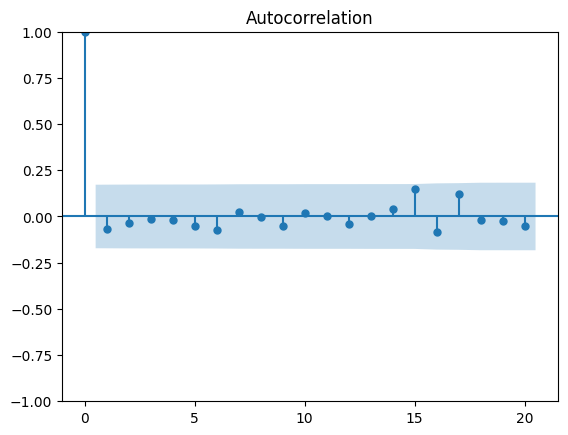

In [11]:
plot_acf(r_btc_log**2, lags=20)
plt.show()